/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:13:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation Metrics:
Accuracy: 0.9995
Precision: 0.8901
Recall: 0.8265
F1 Score: 0.8571
ROC AUC Score: 0.9132
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



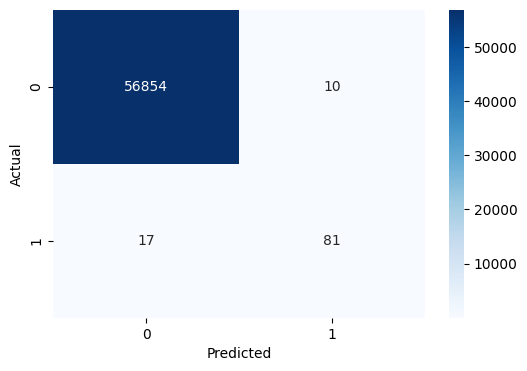

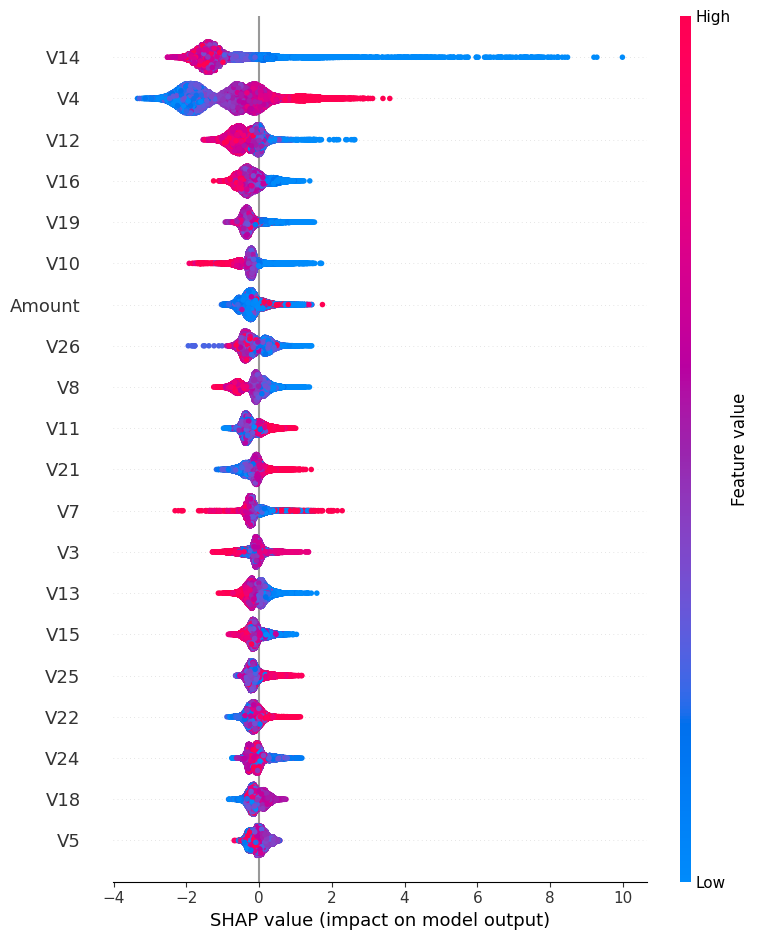

Explaining Fraud Case 1:


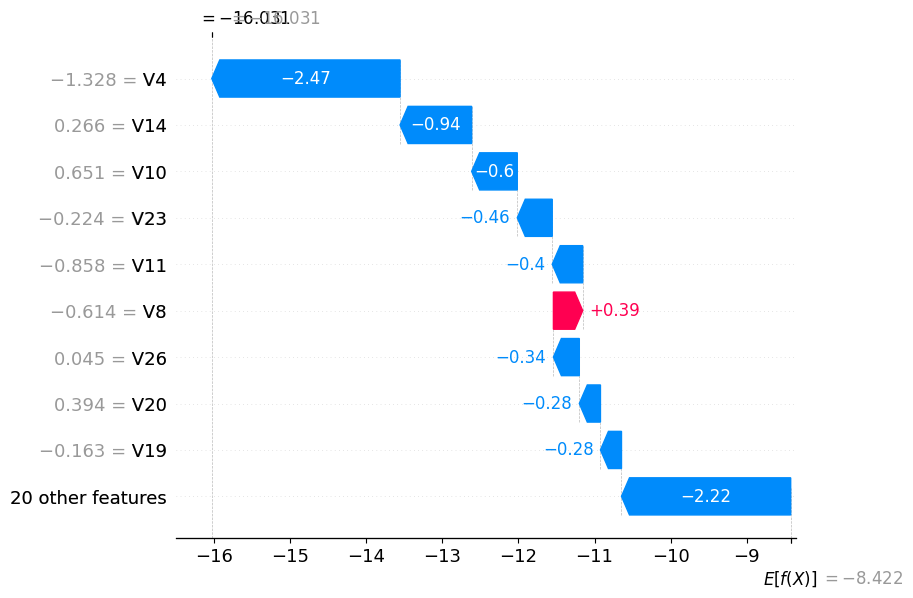

Explaining Fraud Case 2:


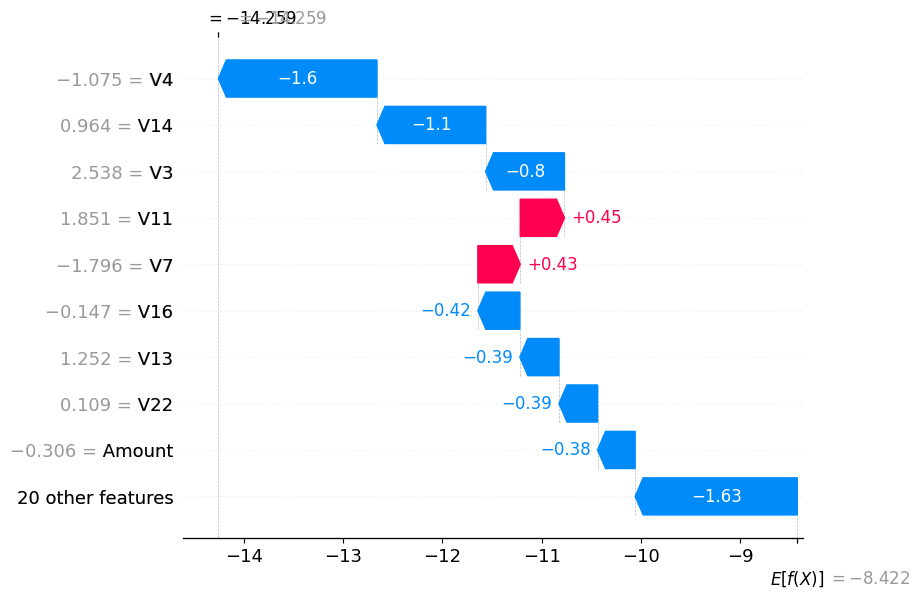

Explaining Fraud Case 3:


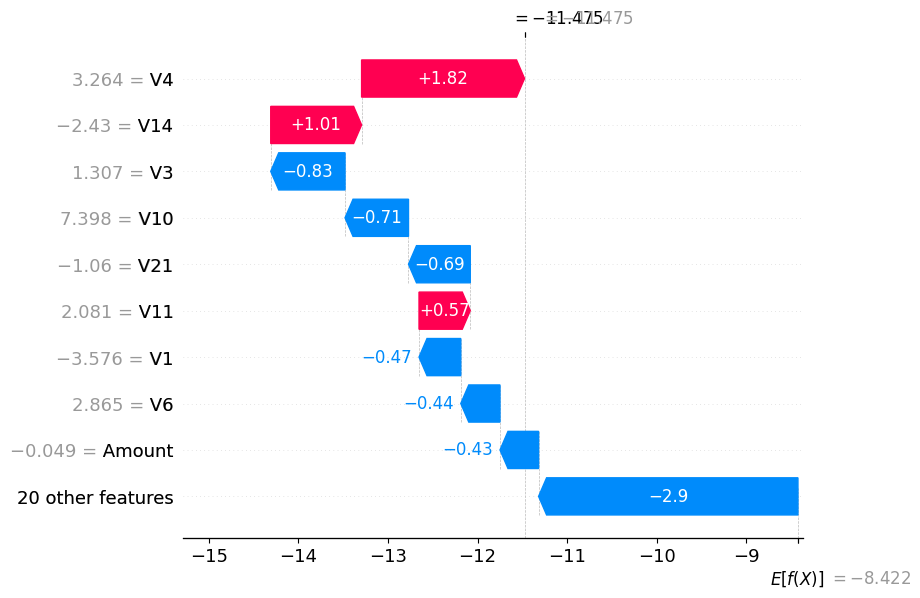

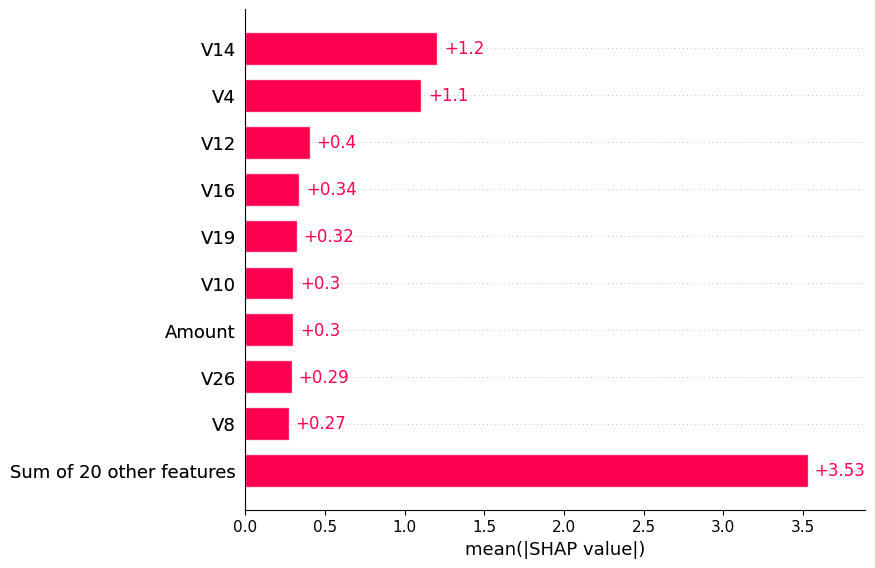


LIME Explanation for First 3 Fraud Cases:


LIME Explanation for Fraud Case 841



LIME Explanation for Fraud Case 1147



LIME Explanation for Fraud Case 3288


In [2]:
!pip install lime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap



# New import for LIME
from lime.lime_tabular import LimeTabularExplainer

# Load and unzip dataset
zip_file_name = "creditcard.csv.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("extracted_data")

extracted_files = os.listdir("extracted_data")
csv_file = [f for f in extracted_files if f.endswith(".csv")][0]
df = pd.read_csv(f"extracted_data/{csv_file}")

# Preprocessing
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

y = df['Class']
X = df.drop(['Class', 'Time'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model training
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SHAP Explainability
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

for i in range(3):
    print(f"Explaining Fraud Case {i+1}:")
    shap.plots.waterfall(shap_values[i])

shap.plots.bar(shap_values)

# ----------------------
# 🔍 LIME Explainability
# ----------------------

print("\nLIME Explanation for First 3 Fraud Cases:\n")


fraud_indices = np.where((y_test.values == 1))[0][:3]

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["Not Fraud", "Fraud"],
    mode="classification"
)

for i in fraud_indices:
    exp = lime_explainer.explain_instance(
        X_test.values[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\nLIME Explanation for Fraud Case {i + 1}")
    exp.show_in_notebook(show_table=True)


